In [4]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

# Setting seed for reproducibility
# np.random.seed(1234)  
# PYTHONHASHSEED = 0

In [5]:
fd_001_train = pd.read_csv('D:\\Desktop\\aerospace\\CMaps\\train_FD001.txt',sep=" ",header=None)

In [6]:
fd_001_test = pd.read_csv('D:\\Desktop\\aerospace\\CMaps\\test_FD001.txt',sep=" ",header=None)

In [7]:
fd_001_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [8]:
fd_001_train.drop(columns=[26,27],inplace=True)

In [9]:
fd_001_test.drop(columns=[26,27],inplace=True)

In [10]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [11]:
fd_001_train.columns = columns

In [12]:
fd_001_test.columns = columns

In [13]:
#initial acquaintance with data
fd_001_train.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [45]:
fd_001_train[['TRA','T2','P2','farB','Nf_dmd','PCNfR_dmd','W32','W31','epr']].apply(pd.value_counts)


,TRA,T2,P2,farB,Nf_dmd,PCNfR_dmd,W32,W31,epr
0.0300,NaN,NaN,NaN,20631.0,NaN,NaN,NaN,NaN,NaN
1.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20631.0
14.6200,NaN,NaN,20631.0,NaN,NaN,NaN,NaN,NaN,NaN
22.8942,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
22.9071,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
39.4100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
39.4300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
100.0000,20631.0,NaN,NaN,NaN,NaN,20631.0,NaN,NaN,NaN
518.6700,NaN,20631.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#delete columns with constant values ​​that do not carry information about the state of the unit
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr','W32','W31'],inplace=True)

## We will display the mutual correlations of the signs on the "heat map", for this we will prepare an additional sign "RUL", showing the number of cycles to failure in the training data

In [47]:
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]


In [48]:
df = prepare_train_data(fd_001_train)

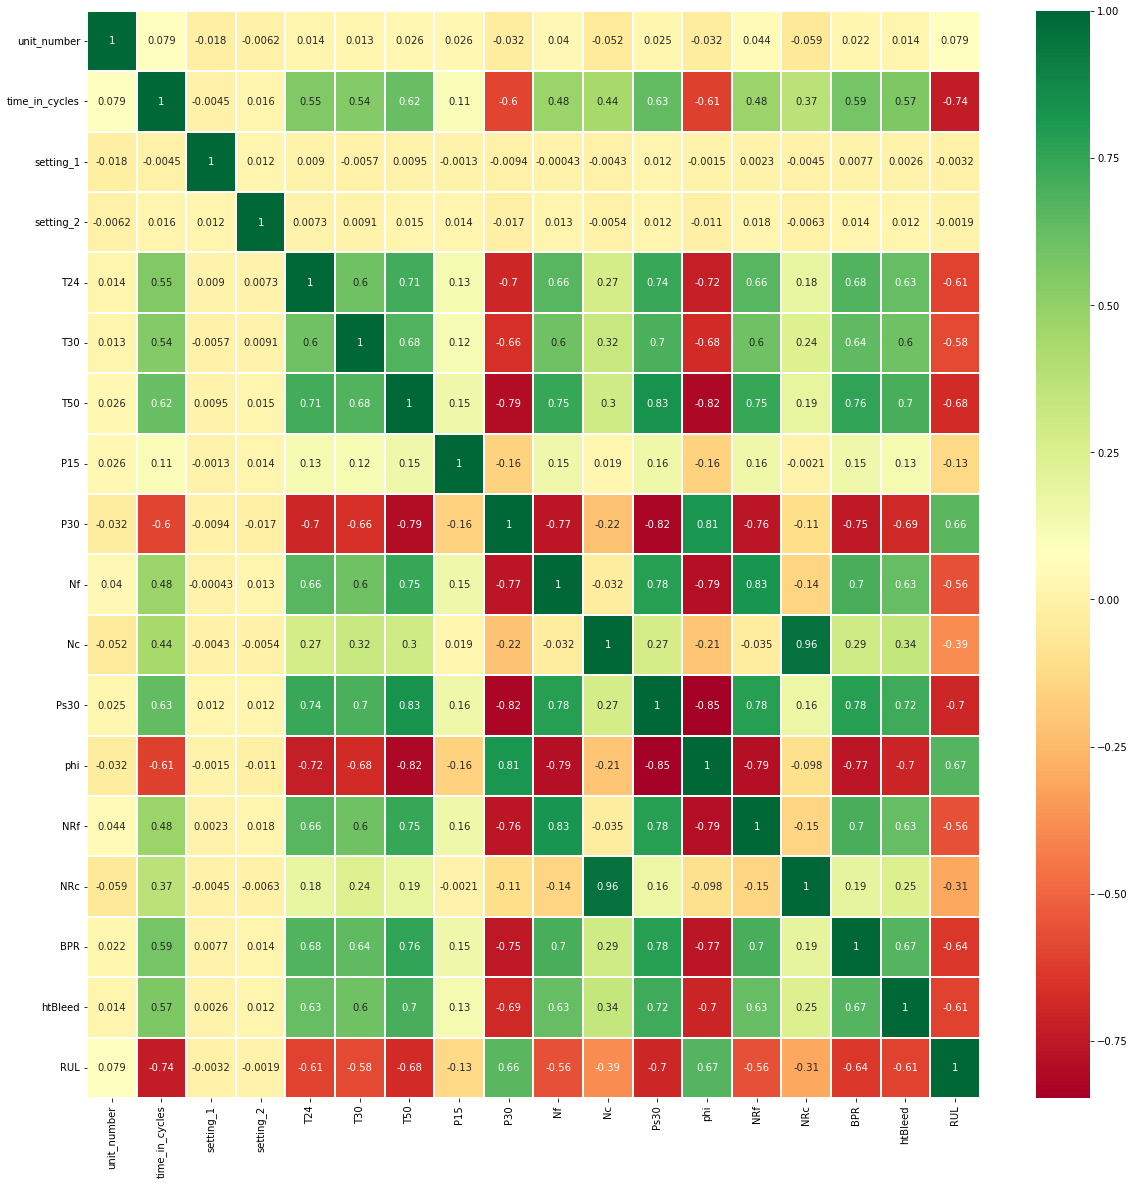

In [49]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

## Error Function for Competitive Data

In [50]:
#Error Function for Competitive Data
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [75]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2), 
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]
    
    print(f' compatitive score {lst[0]}')
    print(f' mean absolute error {lst[1]}')
    print(f' root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]
    

## We remove the properties that weakly correlate with the RUL target: setting_1, setting_2, P15, unit_number, as well as one of the features that are highly correlated with each other (Nc and NRc have a correlation coefficient of 0.96, remove NRc)

In [52]:
unit_number = pd.DataFrame(df["unit_number"])
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

In [53]:
train_df.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,187


In [77]:
train_df.shape

(20631, 13)

## Implementing LSTM

### Data Preprocessing for LSTM 

In [54]:
def lstm_data_preprocessing(raw_train_data, raw_test_data, raw_RUL_data):
    train_df = raw_train_data
    truth_df = raw_RUL_data
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    
    #################
    # TRAIN 
    #################
    
    # we will only make use of "label1" for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within w1 cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
    
    # MinMax normalization (from 0 to 1)
    train_df['cycle_norm'] = train_df['time_in_cycles']
    cols_normalize = train_df.columns.difference(['unit_number','time_in_cycles','RUL','label1','label2']) # NORMALIZE COLUMNS except [id , cycle, rul ....]

    min_max_scaler = MinMaxScaler()

    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)
    print("train_df >> ",train_df.head())
    print("\n")

    
    #################
    # TEST
    #################
    
#     raw_test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
    test_df = raw_test_data.drop(columns = ['setting_1','setting_2','P15','NRc','max'])
    
    # MinMax normalization (from 0 to 1)
    test_df['cycle_norm'] = test_df['time_in_cycles']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)
    
    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number','max']
    truth_df.columns = ['more']
    truth_df['unit_number'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more'] # adding true-rul vlaue + max cycle of test data set w.r.t MID
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['unit_number'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']
    test_df.drop('max', axis=1, inplace=True) 

    # generate label columns w0 and w1 for test data
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
    print("test_df >> ", test_df.head())

    
    ## pick a large window size of 50 cycles
    sequence_length = 50

    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        # for one id I put all the rows in a single matrix
        data_matrix = id_df[seq_cols].values
        num_elements = data_matrix.shape[0]
        # Iterate over two lists in parallel.
        # For example id1 have 192 rows and sequence_length is equal to 50
        # so zip iterate over two following list of numbers (0,112),(50,192)
        # 0 50 -> from row 0 to row 50
        # 1 51 -> from row 1 to row 51
        # 2 52 -> from row 2 to row 52
        # ...
        # 111 191 -> from row 111 to 191
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_matrix[start:stop, :]

    # pick the feature columns 
    sequence_cols = list(test_df.columns[:-3])

    print(sequence_cols)
    
    # TODO for debug 
    # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
    val=list(gen_sequence(train_df[train_df['unit_number']==1], sequence_length, sequence_cols))
    print(len(val))

    # generator for the sequences
    # transform each id of the train dataset in a sequence
    seq_gen = (list(gen_sequence(train_df[train_df['unit_number']==id], sequence_length, sequence_cols)) 
               for id in train_df['unit_number'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print(seq_array.shape)

    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        # For one id I put all the labels in a single matrix.
        # For example:
        # [[1]
        # [4]
        # [1]
        # [5]
        # [9]
        # ...
        # [200]] 
        data_matrix = id_df[label].values
        num_elements = data_matrix.shape[0]
        # I have to remove the first seq_length labels
        # because for one id the first sequence of seq_length size have as target
        # the last label (the previus ones are discarded).
        # All the next id's sequences will have associated step by step one label as target.
        return data_matrix[seq_length:num_elements, :]

    # generate labels
    label_gen = [gen_labels(train_df[train_df['unit_number']==id], sequence_length, ['RUL']) 
                 for id in train_df['unit_number'].unique()]

    label_array = np.concatenate(label_gen).astype(np.float32)
    print(label_array.shape)
    print(label_array)
    
    return seq_array, label_array, test_df, sequence_length, sequence_cols

LSTM Model


In [55]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lstm_train(seq_array, label_array, sequence_length):
    # The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
    # Dropout is also applied after each LSTM layer to control overfitting. 
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff 
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    #           callbacks = [keras.callbacks.EarlyStoping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
    #                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
    #           )

    # list all data in history
    print(history.history.keys())
    
    return model, history

Model Evaluation on Test set


In [56]:
def lstm_test_evaluation_graphs(model, history, seq_array, label_array):
    # summarize history for R^2
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred )
    test_set.head()
    # test_set.to_csv('submit_train.csv', index = None)

Model Evaluation on Validation set

In [57]:
def lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols):
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [lstm_test_df[lstm_test_df['unit_number']==id][sequence_cols].values[-sequence_length:] 
                           for id in lstm_test_df['unit_number'].unique() if len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

    # Similarly, we pick the labels
    y_mask = [len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length for id in lstm_test_df['unit_number'].unique()]
    label_array_test_last = lstm_test_df.groupby('unit_number')['RUL'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

    estimator = model

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    print(test_set.head())

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test)
    plt.plot(y_true_test, color="orange")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    # fig_verify.savefig("model_regression_verify.png")
    return scores_test[1], scores_test[2]

### References of LSTM


- [1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- [3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA 
- [4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- [5] https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM

### Function for creating and training models using the "Random forest" and "XGBoost" algorithms


In [68]:
#function for creating and training models using the "Random forest" and "XGBoost" algorithms
def train_models(data,model = 'FOREST'):
    
    if model != 'LSTM':
        X = data.iloc[:,:14].to_numpy() 
        Y = data.iloc[:,14:].to_numpy()
        Y = np.ravel(Y)

    if model == 'FOREST':
         #  parameters for models are selected in a similar cycle, with the introduction 
         # of an additional param parameter into the function:
         #for i in range(1,11):
         #     xgb = train_models(train_df,param=i,model="XGB",)
         #     y_xgb_i_pred = xgb.predict(X_001_test)
         #     print(f'param = {i}')
         #     score_func(y_true,y_xgb_i_pred)
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
        model.fit(X,Y)
        return model
    
    elif model == 'XGB':
        model = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                           colsample_bytree=0.5, max_depth=3,silent=True)
        model.fit(X,Y)
        return model
    
    elif model == 'LSTM':
        seq_array, label_array, lstm_test_df, sequence_length, sequence_cols = lstm_data_preprocessing(data[0], data[1], data[2])
        model_instance, history = lstm_train(seq_array, label_array, sequence_length)
        return model_instance, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols
            
    return

In [58]:
#function for joint display of real and predicted values

def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION OF Real and Predicted values')
    plt.show()
    return

# Prepare test data for classification
only the features used in the training are needed and a line with the maximum value for this engine time_in_cycles (last)

In [59]:
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [60]:
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']

In [61]:
fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')

In [62]:
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()

In [63]:
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)

In [64]:
X_001_test = test.to_numpy()

In [65]:
X_001_test.shape

(100, 14)

In [76]:
fd_001_test.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,max
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31


## Prediction of the final result for all engines


## Let's train the model on training data without the deleted properties 'unit_number', 'setting_1', 'setting_2', 'P15', 'NRc'

In [69]:
model_1 = train_models(train_df)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [70]:
y_pred = model_1.predict(X_001_test)

NameError: name 'model_1' is not defined

In [73]:
RUL = pd.read_csv("D:\\Desktop\\aerospace\\CMaps\\RUL_FD001.txt",sep=" ",header=None)

In [ ]:
y_true = RUL[0].to_numpy()

In [ ]:
RUL.head()

## Competitive score, the average absolute error, the root mean square error and the coefficient of determination of the resulting model:

In [ ]:
RF_individual_scorelst = score_func(y_true, y_pred)

In [ ]:
plot_result(y_true,y_pred)

### LSTM funtion calling

In [74]:
train_df_lstm = pd.concat([unit_number, train_df], axis=1)
model, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols = train_models([train_df_lstm, fd_001_test, RUL.copy()], "LSTM")

train_df >>     unit_number  time_in_cycles       T24       T30       T50       P30  \
0            1               1  0.183735  0.406802  0.309757  0.726248   
1            1               2  0.283133  0.453019  0.352633  0.628019   
2            1               3  0.343373  0.369523  0.370527  0.710145   
3            1               4  0.343373  0.256159  0.331195  0.740741   
4            1               5  0.349398  0.257467  0.404625  0.668277   

         Nf        Nc      Ps30       phi       NRf       BPR   htBleed  RUL  \
0  0.242424  0.109755  0.369048  0.633262  0.205882  0.363986  0.333333  191   
1  0.212121  0.100242  0.380952  0.765458  0.279412  0.411312  0.333333  190   
2  0.272727  0.140043  0.250000  0.795309  0.220588  0.357445  0.166667  189   
3  0.318182  0.124518  0.166667  0.889126  0.294118  0.166603  0.333333  188   
4  0.242424  0.149960  0.255952  0.746269  0.235294  0.402078  0.416667  187   

   label1  label2  cycle_norm  
0       0       0     0.00000

KeyError: "['W31', 'W32'] not in index"

In [ ]:
lstm_test_evaluation_graphs(model, history, seq_array, label_array)

In [ ]:
MAE, R2 = lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols)
# mae, rmse, r2
LSTM_individual_scorelst = [round(MAE,2), 0, round(R2,2)*100]


### Let’s try to improve the algorithm for predicting the results, for this we will train the model each time again for each individual prediction, discarding in the training array the values ​​on the timeline (time_in_cycles) are smaller than the last value in the fd_001_test array, that is, lower than the value for which RUL should be predicted (remaining useful life)

In [ ]:
# to discard values in the training array, use the factor parameter in
# prepare_train_data functions, in test_data are samples prepared for recognition, in the first column of which
# - value of time in cycles for which RUL is predicted
def single_train(test_data,train_data,algorithm):
    y_single_pred = []
    for sample in tqdm(test_data):
        time.sleep(0.01)
        single_train_df = prepare_train_data(train_data, factor = sample[0])
        single_train_df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
        model = train_models(single_train_df,algorithm)
        y_p = model.predict(sample.reshape(1,-1))[0]
        y_single_pred.append(y_p)
    y_single_pred = np.array(y_single_pred)
    return y_single_pred

In [ ]:
y_single_pred = single_train(X_001_test,fd_001_train,'FOREST')

### Display the results.

In [ ]:
plot_result(y_true,y_single_pred)


## Competitive score, average absolute error and coefficient of determination of the improved model

In [ ]:
RF_SingleTrain_scorelst = score_func(y_true, y_single_pred)

### Using a modified algorithm with individual training and prediction, it was possible to significantly reduce the MAE and increase the R2 score

### Since the sensor data is very noisy, we will try the following approach to improve the prediction: we will make predictions based on not one (last) “slice” of the sensor values, as was done above, but some optimized (for example, by determination coefficient or mean absolute error) number of previous breaking values. To display the final value of RUL, we use the average value of all predictions

In [ ]:
def prepare_test_data(fd_001_test,n=0):
    test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max'] - n].reset_index()
    test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
    X_return = test.to_numpy()
    return X_return

In [ ]:
N=5
y_n_pred = y_single_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'FOREST')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

### We calculate the average value of predictions for each engine

In [ ]:
y_multi_pred = np.mean(y_n_pred,axis = 0)

In [ ]:
RF_5avg_scorelst = score_func(y_true,y_multi_pred)

We display the results for the average of 5 predictions

In [ ]:
plot_result(y_true,y_multi_pred)

In [ ]:
N=10

# In order not to recalculate the average result for 5 predictions, the stored value y_multi_pred
# is entered in y_n_pred, then the predictions for 5,6,7 .... lines from the last for the given engine
y_n_pred = y_multi_pred
for i in range(5,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'FOREST')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

In [ ]:
y_multi_pred_10 = np.mean(y_n_pred,axis = 0)

In [ ]:
score_func(y_true,y_multi_pred_10)


We display the results for an average of 10 predictions

In [ ]:
plot_result(y_true,y_multi_pred_10)

Obviously, with a further increase in the number of predictions for deriving the average, the quality of the model’s answers does not improve, in the future we will use y_multi_pred (the average of 5 individual predictions)

### Compare the results with another model - XGBoost

In [ ]:
xgb = train_models(train_df,model="XGB")

In [ ]:
y_xgb_pred = xgb.predict(X_001_test)

In [ ]:
XGB_individual_scorelst = score_func(y_true,y_xgb_pred)

According to regression algorithm estimation metrics, the result is worse than for a "random forest"
Metrics for RandomForestRegressor

Competitive Score 1057.2

 mean absolute error 19.25
 
 root mean squared error 24.45219826518671
 
 R2 score 0.65

In [ ]:
plot_result(y_true,y_xgb_pred)

Individual predictions for XGBoost:

In [ ]:
y_single_xgb_pred = single_train(X_001_test,fd_001_train,'XGB')

In [ ]:
XGB_SingleTrain_scorelst = score_func(y_true,y_single_xgb_pred)

In [ ]:
plot_result(y_true,y_single_xgb_pred)

In [ ]:
N=5
y_n_pred = y_single_xgb_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = single_train(X_001_test,fd_001_train,'XGB')    
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred)) 

In [ ]:
y_5_pred_xgb = np.mean(y_n_pred,axis = 0)

In [ ]:
XGB_5avg_scorelst = score_func(y_true,y_5_pred_xgb)

Similarly, all metrics, except for the competitive error function (compared to the joint prediction) have improved their value

In [ ]:
plot_result(y_true,y_5_pred_xgb)

In [ ]:
# Bar plots for comparision
def Bar_Plots(RF_score_lst, XGB_score_lst, LSTM_score_lst=0):
    hue = ["mae","rmse", "r2"]
    
    if LSTM_score_lst != 0: 
        df = pd.DataFrame(zip(hue*3, ["RFRegrssor"]*3+["LSTM"]*3+["XGBRegressor"]*3, RF_score_lst+LSTM_score_lst+XGB_score_lst), columns=["Parameters", "Models", "Scores"])
    else:
        df = pd.DataFrame(zip(hue*3, ["RFRegrssor"]*3+["XGBRegressor"]*3, RF_score_lst+XGB_score_lst), columns=["Parameters", "Models", "Scores"])

    print(df.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Models", y="Scores", hue="Parameters", data=df)
    plt.show()

In [ ]:
# Individual Paramters comparision
# LSTM_individual_scorelst = [17.36, 0, 75] # Comment this line when lstm runs 60 epoches
Bar_Plots(RF_individual_scorelst, XGB_individual_scorelst, LSTM_individual_scorelst)

In [ ]:
# Single Train comparison
Bar_Plots(RF_SingleTrain_scorelst, XGB_SingleTrain_scorelst)

In [ ]:
# Avg of 5 comparision
Bar_Plots(RF_5avg_scorelst, XGB_5avg_scorelst)

In [ ]:
compare = pd.DataFrame(list(zip(y_true, y_pred, y_single_pred,y_multi_pred,y_multi_pred_10,y_xgb_pred,y_single_xgb_pred)), 
               columns =['True','Forest_Predicted','Forest_Single_predicted','multi_5','multi_10'
                         ,'XGBoost','XGBoost_single']) 
compare['unit_number'] = compare.index + 1

In [ ]:
compare['Predicted_error'] = compare['True'] - compare['Forest_Predicted']
compare['Single_pred_error'] = compare['True'] - compare['Forest_Single_predicted']
compare['multi_5_error'] = compare['True'] - compare['multi_5']
compare['multi_10_error'] = compare['True'] - compare['multi_10']
compare['xgb_error'] = compare['True'] - compare['XGBoost']
compare['xgb_single_error'] = compare['True'] - compare['XGBoost_single']
ax1 = compare.plot(subplots=True, sharex=True, figsize=(20,20))

Errors in all algorithms are strongly correlated, to further improve the forecasts of the algorithm, pre-processing of training and possibly test data is necessary to eliminate outliers

To obtain practical value from the data, we use binary classification algorithms for maintenance planning, calculate what profit (or loss) analysis and maintenance planning can bring for a hypothetical airline

https://github.com/Samimust/predictive-maintenance/blob/master/Model%20Selection%20-%20Binary%20Classifiaction.ipynb


Let's create a classifier that will answer the question: "Current engine resource more or less than 10 cycles"? It is assumed that this is sufficient time to prepare and start maintenance.

## Expected Value Calculation:
Based on the book: Data Science for Business, https://www.amazon.com/Data-Science-Business-Data-Analytic-Thinking/dp/1449361323 . Expected Value is a method to compare different classification models by constructing cost-benefit matrix in line with the confusion matrix, and then convert model performance to a single monetary value by multiplying confusion matrix into the cost-benefit matrix.

Cost-benefit matrix should be designed by domain expert. Let us assume the following:

True Positive (TP) has benefit of USD 300K: engines that need maintenance and correctly selected by the model.

True Negative (TN) has benefit of USD 0K: engines that are OK and not selected by the model.

False Positive (FP) has cost of USD -100K: engines that are OK but selected by the model.

False Negative (FN) has cost of USD -200K: engines that need maintenance but not selected by the model.

In [ ]:
# formation of the target variable label, TTF - time to failure
TTF = 10
train_df['label'] = np.where(train_df['RUL'] <= TTF, 1, 0 )

formation of the target variable label, TTF - time to failure

In [ ]:
train_df.head()


We display the scattering diagram of two parameters with a separation according to the target attribute

In [ ]:
sns.scatterplot(x="Nc", y="T50", hue="label", data=train_df)
plt.title('Scatter patter Nc or T50')

## Prepare data for classification

In [ ]:
# exclude the RUL property and form an array of attributes and the target variable
X_class = train_df.iloc[:,:14].to_numpy() 
Y_class = train_df.iloc[:,15:].to_numpy()
Y_class = np.ravel(Y_class)

In [ ]:
# Class balancing to improve classifier performance
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X_class, Y_class)
X_resampled, y_resampled = ros.fit_sample(X_class, Y_class)
print('The number of elements before the operation:', len(X_class))
print('The number of elements after the operation:', len(X_resampled))

In [ ]:
# Here we divide the data into the training sample and the test one, 
#test_size = 0.2 sets the proportion of the test sample = 20%
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = 0.2,random_state = 3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=70 ,max_depth = 8, random_state=193)
forest.fit(X_train,y_train)

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def classificator_score(y_,y_p):
    print(f' accuracy score {round(accuracy_score(y_, y_p),2)}')
    print(f' precision score {round(precision_score(y_, y_p),2)}')
    print(f' recall score {round(recall_score(y_, y_p),2)}')
    print(f' F1 score {round(f1_score(y_, y_p),2)}')
    return

Metrics for RandomForestClassifier

In [ ]:
classificator_score(y_test,forest.predict(X_test))

In [ ]:
y_xgb_pred = model_xgb.predict(X_001_test)
classificator_score(y_test,model_xgb.predict(X_test))

In [ ]:
test.head()

In [ ]:
X_001_test = test.to_numpy()

we will form a generalized table for predicted and correct values

In [ ]:
# prediction for X_001_test, time to failure = TTF = 10
predicted = pd.DataFrame()
predicted ['forest'] =  forest.predict(X_001_test)
predicted['XGB'] = y_xgb_pred
predicted['RUL']=RUL[0]
predicted['true_label'] = np.where(y_true <= TTF, 1, 0 )
predicted['unit_number'] = predicted.index + 1

In [ ]:
predicted.head()

In [ ]:
# true TTF values <= 10
predicted[predicted['true_label'] == 1]

In [ ]:
# engines for which the RandomForest classification algorithm gave incorrect predictions
predicted[predicted['true_label'] != predicted['forest']]

In [ ]:
# engines for which the XGBoost classification algorithm gave incorrect predictions
predicted[predicted['true_label'] != predicted['XGB']]

In [ ]:
y_true_class = np.where(y_true <= TTF, 1, 0 )
y_pred_class = predicted['forest'].tolist()

Function for calculating expected profits as described above

In [ ]:
def expected_profit(y_true,y_pred):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(y_true)):
        if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
            FP += 1
        elif (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
            FN += 1
        elif (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
            TN += 1
        else:
            TP += 1
    print(f'TP ={TP}, TN = {TN}, FP = {FP}, FN = {FN}')
    print (f'expected profit {(300 * TP - 200 * FN - 100 * FP) * 1000}')
    return 
        

In [ ]:
def confusion_matrix(actual, predicted):
    plt.figure(figsize=(5,5))
    sns.heatmap(sklearn.metrics.confusion_matrix(actual,predicted),annot=True,fmt='.5g')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.show()

In [ ]:
# forest
expected_profit(y_true_class,y_pred_class)
confusion_matrix(y_true_class, y_pred_class)

In [ ]:
# Xgboost
expected_profit(y_true_class,y_xgb_pred)
confusion_matrix(y_true_class, y_xgb_pred)

### ROC(Receiver Operating Characteristic) Curve 

In [ ]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_true_class,  y_xgb_pred)                      
fpr_RF, tpr_RF, _ = metrics.roc_curve(y_true_class,  y_pred_class)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)
auc_RF = metrics.auc(fpr_RF,  tpr_RF)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of XGB(area = %0.2f)' % auc_xgb)
plt.plot(fpr_RF,tpr_RF, label='ROC curve of RF(area = %0.2f)' % auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Conclusion: the proposed classification algorithms show useful results on test data and can be used to obtain cost savings during preventive maintenance of aircraft engines, to estimate the approximate remaining engine life (if the corresponding error is permissible under specific conditions) it can be used in conjunction with the regression algorithms described above